## Lab 3. Text classification using Bag-of-Words representation

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.datasets import make_classification
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### 1. Bag-of-Words

Am vazut in laboratorul trecut cum putem folosi diverse tehnici pentru a reduce un text la o lista de cuvinte (tokens). Am vazut cum putem elimina cuvintele care au o incarcatura semantica redusa (stopwords) si cum putem normaliza tokenii, aducandu-i la o forma unica pentru inlfexiuni diferite ale acestora (lematizare, stemming).

Pentru a antrena un model de Machine Learning avem nevoie sa mai facem cativa pasi. Aceste reprezentari determinate anterior (liste de tokens) trebuie traduse in reprezentari numerice vectoriale (fiecarui text ii vom asocia un vector, iar toti vectorii corespunzatori textelor vor avea aceeasi dimensiune).

O astfel de metoda este reprezentarea textelor folosind tehnica Bag-of-Words. Aceasta metoda porneste de la un vocabular de cuvinte, un sir $[w_1, w_2, \ldots, w_n]$, unde $w_i$ reprezinta un cuvant din vocabular. Vocabularul poate fi stabilit de la inceput sau determinat pe baza listelor preprocesate de tokeni (putem defini vocabularul ca cei mai frecventi $n$ tokens din aceste liste).

Un text (lista de tokens) poate fi acum transformat intr-un vector de dimensiune $n$: $(a_1, \ldots, a_n)$ unde $a_i=1$ daca cuvantul $w_i$ apare cel putin o data in text, respectiv $a_i=0$ altfel. Aceasta reprezentare o mai numim si Bag-of-Words binar.

O altfel de reprezentare asemanatoare poate fi bazata pe frecvente, $a_i$ reprezinta numarul de aparitii ale cuvantului $w_i$ in text.

In [2]:
# exemplu texte (procesate ca liste de tokens)
texts = [
    ["love", "fun", "fun", "play", "happy", "sad"],
    ["love", "happy", "love", "love", "tears"],
    ["sad", "tears", "tears"],
]

# exemplu vocabular
vocab = ["love", "fun", "tears", "sad", "happy"]

In [3]:
# reprezentare BoW binar
repr_bin = [
    [1, 1, 0, 1, 1],
    [1, 0, 1, 0, 1],
    [0, 0, 1, 1, 0],
]

In [4]:
# reprezentare BoW pe baza de frecvente
repr_fr = [
    [1, 2, 0, 1, 1],
    [3, 0, 1, 0, 1],
    [0, 0, 2, 1, 0],
]

Aceasta logica poate fi implementata usor, dar aceasta poate fi regasita (impreuna cu alte detalii interesante) in clasa [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) din scikit-learn.

Intr-un obiect de acest tip putem incorpora si logica de preprocesare+tokenizare a textelor.

In [5]:
texts = [
    "Love fun fun Play Happy sad",
    "love happy Love love tears",
    "sad Tears tears",
]

Implementam o preprocesare rudimentara a acestor texte, transformam toate majusculele in litere mici, iar pentru tokenizare dam split dupa spatiu. In cazul in care lucrati cu texte mai complexe, in acesti pasi includem ce am discutat in laboratorul anterior (eliminare de punctuatie, tokenizare, eliminare de stopwords, lematizare, stemming etc.).

In [6]:
def dummy_preprocess(text):
    return text.lower()

def dummy_tokenize(text):
    return text.split(" ")

test_preprocess = dummy_preprocess(texts[0])
test_tokens = dummy_tokenize(test_preprocess)
print(test_tokens)

['love', 'fun', 'fun', 'play', 'happy', 'sad']


In [7]:
cv = CountVectorizer(
    preprocessor=dummy_preprocess,  # metoda de preprocesare a textelor
    tokenizer=dummy_tokenize,       # metoda de tokenizare
    token_pattern=None,             # nu avem nevoie de acest argument intrucat avem propria metoda de tokenizare
    max_features=5,                 # dimensiunea vocabularului care va fi determinat
    binary=True,                    # BoW binar
)

# metoda `fit` este folosita in acest caz pentru a determina vocabularul
# (pastrand cei mai frecventi `max_features` tokens din textele procesate)
cv.fit(texts)

print(sorted(list(cv.vocabulary_.keys())))

# calculeaza reprezentarile textelor (feature vectors)
features = cv.transform(texts)
print(features.shape)
print(type(features))
print(features.toarray())  # convertim la numpy array

['fun', 'happy', 'love', 'sad', 'tears']
(3, 5)
<class 'scipy.sparse._csr.csr_matrix'>
[[1 1 1 1 0]
 [0 1 1 0 1]
 [0 0 0 1 1]]


In [8]:
cv = CountVectorizer(
    preprocessor=dummy_preprocess, 
    tokenizer=dummy_tokenize,       
    token_pattern=None,             
    max_features=5,                 
    binary=False,                   # BoW bazat pe frecvente
)

cv.fit(texts)

print(sorted(list(cv.vocabulary_.keys())))

# calculeaza reprezentarile textelor (feature vectors)
features = cv.transform(texts)
print(features.shape)
print(type(features))
print(features.toarray())  # convertim la numpy array

['fun', 'happy', 'love', 'sad', 'tears']
(3, 5)
<class 'scipy.sparse._csr.csr_matrix'>
[[2 1 1 1 0]
 [0 1 3 0 1]
 [0 0 0 1 2]]


O alternativa a acestor reprezentari este numararea n-gramelor.

Sa luam spre exemplu fraza "I am not happy". Metoda de mai devreme ne reda reprezentarea acestei fraza ca o multime de cuvinte (indiferent de ordinea lor). Astfel, aceasta reprezentare indica prezenta cuvantului "happy", ceea ce ar face un model sa interpreteze textul intr-un cadru pozitiv. Dar vedem clar ca nu este aceasta situatia. Daca in loc de tokeni simpli (unigrame) am numara secvente de cate 2 tokeni consecutivi (bigrame), am putea identifica prezenta bigramei ("not", "happy") care intuim ca nu ar avea ce cauta intr-un text cu sentiment pozitiv.

In [9]:
cv = CountVectorizer(
    preprocessor=dummy_preprocess, 
    tokenizer=dummy_tokenize,       
    token_pattern=None,             
    max_features=5,                 
    ngram_range=(2, 2),                   # construim un vocabular de bigrame
)

cv.fit(texts)

print(sorted(list(cv.vocabulary_.keys())))

# calculeaza reprezentarile textelor (feature vectors)
features = cv.transform(texts)
print(features.shape)
print(type(features))
print(features.toarray())  # convertim la numpy array

['fun fun', 'fun play', 'happy love', 'happy sad', 'love fun']
(3, 5)
<class 'scipy.sparse._csr.csr_matrix'>
[[1 1 0 1 1]
 [0 0 1 0 0]
 [0 0 0 0 0]]


### 2. Feature Scaling

#### Standard Scaling

Avand determinati feature vectorii se pune urmatoarea problema: stiind ca un feature reprezinta frecventa unui cuvant din vocabular in texte, iar pentru anumite cuvinte in mod natural aceasta frecventa este mai mare (Zipf's Law), faptul ca anumite feature-uri au valoare absoluta mai mare decat alta poate influenta diversi algoritmi de ML sa trateze acele feature-uri cu mai multa importanta (ceea ce de multe ori nu este corect).

Prin Standard Scaling presupunem ca fiecare feature corespunde cate unei variabile aleatoare distribuita normal. Putem deci estima pentru fiecare astfel de variabila media si deviatia standard, apoi prin procesul de standardizare putem reduce valorile feature-ului corespunzator la o distributie normala de medie $0$ si varianta $1$.

In [10]:
x_train = np.array([[1, -1, 2], [2, 0, 0], [0, 1, -1]], dtype=np.float64)
x_test = np.array([[-1, 1, 0]], dtype=np.float64)
 
# clasa folosita pentru standardizare
scaler = preprocessing.StandardScaler()

# calculam media si deviatia standard pentru feature vectorii de antrenare
scaler.fit(x_train)

print('media =', scaler.mean_)  
print('std =', scaler.scale_) 

# scalam vectorii de train
scaled_x_train = scaler.transform(x_train)
print(scaled_x_train)  

# scalam vectorii de test
# (folosim media si std determinate din train, datele de test nu sunt folosite pentru a determina hiperparametrii)
scaled_x_test = scaler.transform(x_test)
print(scaled_x_test)     

media = [1.         0.         0.33333333]
std = [0.81649658 0.81649658 1.24721913]
[[ 0.         -1.22474487  1.33630621]
 [ 1.22474487  0.         -0.26726124]
 [-1.22474487  1.22474487 -1.06904497]]
[[-2.44948974  1.22474487 -0.26726124]]


#### Normalizare L1 si L2

Acest mod de normalizare este mai simplu intrucat nu mai necesita determinarea unor parametrii. Fiecare feature vector este impartit prin norma sa (L1 sau L2), obtinand astfel ca toti vectorii corespunzatoari textelor sa aiba norma 1.

$$x{\_}scaled_1 = \frac{X}{\mid\mid X \mid\mid_1}, \mid\mid X \mid\mid_1 = \sum_{i=1}^{i=n}\mid x_i \mid $$
$$x{\_}scaled_2 = \frac{X}{\mid\mid X \mid\mid_2}, \mid\mid X \mid\mid_2 = \sqrt{\sum_{i=1}^{i=n} x_i ^ 2 }$$

In [11]:
x_train = np.array([[1, -1, 2], [2, 0, 0], [0, 1, -1]], dtype=np.float64)
x_test = np.array([[-1, 1, 0]], dtype=np.float64)

# clasa folosita pentru normalizare
scaler = preprocessing.Normalizer(norm='l1') 
# scaler = preprocessing.Normalizer(norm='l2')

# `fit` aici nu face absolut nimic
scaler.fit(x_train)

# scalam vectorii de train
scaled_x_train = scaler.transform(x_train)
print(scaled_x_train)  

# scalam vectorii de test
scaled_x_test = scaler.transform(x_test)
print(scaled_x_test)  

[[ 0.25 -0.25  0.5 ]
 [ 1.    0.    0.  ]
 [ 0.    0.5  -0.5 ]]
[[-0.5  0.5  0. ]]


### 3. Tf-Idf

O alta metoda de normalizare a feature-urilor pentru reprezentarea Bag-of-Words este **Tf-Idf**.

**Term Frequency (TF)** numara pentru un token si un document de cate ori apare tokenul respectiv in document.

O varianta de calcul pentru un token $t$ si un document $d$ ar fi: $\textrm{tf}(t, d) = log(1 + \textrm{frecv}(t, d))$.

**Inverse Document Frequency (IDF)** iluestreaza cat de comun sau rar este un cuvant intr-un intreg corpus (multime de texte). Astfel, cu cat aceasta valoare se apropie de $0$ tokenul respectiv este mai comun.

Pentru un token $t$, o multime de $N$ documente $D$, putem calcula IDF astfel: $\textrm{idf}(t, D) = \log(\frac{N}{|\{d \in D: t \textrm{ apare in } d\}|})$.

**TF-IDF** combina cele doua formule:
$$\textrm{tfidf}(t, d, D) = \textrm{tf}(t, d) \cdot \textrm{idf}(t, D)$$.

Mai multe informatii [aici](https://ro.wikipedia.org/wiki/Tf%E2%80%93idf).

In [12]:
# exemplu TfidfVectorizer

cv = TfidfVectorizer(
    preprocessor=dummy_preprocess, 
    tokenizer=dummy_tokenize,       
    token_pattern=None,             
    max_features=5,
)

cv.fit(texts)

print(sorted(list(cv.vocabulary_.keys())))

# calculeaza reprezentarile textelor (feature vectors)
features = cv.transform(texts)
print(features.shape)
print(type(features))
print(features.toarray())  # convertim la numpy array

['fun', 'happy', 'love', 'sad', 'tears']
(3, 5)
<class 'scipy.sparse._csr.csr_matrix'>
[[0.83513325 0.31757018 0.31757018 0.31757018 0.        ]
 [0.         0.30151134 0.90453403 0.         0.30151134]
 [0.         0.         0.         0.4472136  0.89442719]]


### 4. Clasificare folosind Scikit-Learn

In [13]:
# generam o problema "dummy" de clasificare:
# - 1000 de feature vectori de dimensiune 10 (din care doar 5 sunt relevanti pentru clasificare)
# - fiecarui vector ii este asociat un label (0, 1 sau 2)
X, y = make_classification(
    n_samples=1000, n_classes=3, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 10) (800,)
(200, 10) (200,)


Vom folosi pentru clasificare un decision tree (mai multe detalii [aici](https://en.wikipedia.org/wiki/Decision_tree_learning))

In [14]:
# initializam un astfel de algoritm cu anumiti hiperparametri
clf = DecisionTreeClassifier(max_depth=3, min_samples_split=5)

# antrenam folosind datele de train
clf.fit(X_train, y_train)

# folosim modelul pentru a prezice labelurile de test
y_test_predict = clf.predict(X_test)

### 5. Metrici

Avem mai multe metrici pe care le putem folosi pentru a determina performanta unui astfel de model. Pornim de la cazul simplu al unei probleme de clasificare binara (0/1).

In [15]:
y_true    = [0, 0, 0, 1, 1, 1, 1]
y_predict = [0, 1, 0, 0, 1, 1, 0]

Definim:
 * TP (true positive): numarul de labeluri 1 prezise corect
 * FP (false positive): numarul de labeluri 1 prezise incorect
 * TN (true negative): numarul de labeluri 0 prezise corect
 * FN (false negative): numarul de labeluri 0 prezise incorect
 
Acuratetea se calculeaza dupa formula:
$$\frac{TP+TN}{TP+FP+TN+FN}$$

Cu alte cuvinte cate labeluri au fost prezise corect din totalul de predictii.

In [16]:
print("Accuracy:", metrics.accuracy_score(y_true, y_predict))

Accuracy: 0.5714285714285714


Acuratetea nu este mereu metrica preferabila. In cazul unei probleme dezechilibrate (imbalanced) in care $99\%$ din obiecte au labelul $0$ si doar $1\%$ au labelul $1$, un clasificator care prezice doar labelul $0$ pentru toate exemplele ar avea acuratete $99\%$! Daca problema ar fi fost detectare de spam, sau detectarea simptomelor asociate unui anumit tip de cancer, un astfel de model nu ar fi considerat unul performant.

Introducem astfel alte cateva metrici:
 * P (precision): $\frac{TP}{TP+FP}$ (dintre toate predictiile 1, cate sunt corecte?)
 * R (recall): $\frac{TP}{TP+FN}$ (dintre toate obiectele din clasa 1, cate am reusit sa prezicem corect?)
 * F1: $\frac{2PR}{P+R}$ (media armonica intre precision si recall)

In [17]:
print("Precision:", metrics.precision_score(y_true, y_predict))
print("Recall:", metrics.recall_score(y_true, y_predict))
print("F1:", metrics.f1_score(y_true, y_predict))

Precision: 0.6666666666666666
Recall: 0.5
F1: 0.5714285714285715


In cazul problemelor de clasificare de tip multi-class (mai mult de 2 clase). Acuratetea pastreaza acelasi sens de "cate predictii sunt corecte din totalul predictiilor".

Precision, Recall si F1 se calculeaza intr-o maniera one-vs-rest. Astfel fixand o anumita clasa, transformam labelurile in $1$ daca labelul original corespunde clasei fixate si $0$ altfel. Putem acum calcula aceste metrici in cazul binar. Rezultatele obtinute pentru fiecare astfel de fixare sunt acumulate si rezultatul final este media acestora (calculata ca medie aritmetica - macro, sau ca medie ponderata - weighted in care ponderile sunt date de numarul de exemple din clasa respectiva).

In [18]:
# calculam acuratete si F1 pentru clasificarea de mai devreme
print("Accuracy:", metrics.accuracy_score(y_test, y_test_predict))
print("F1 (macro):", metrics.f1_score(y_test, y_test_predict, average="macro"))
print("F1 (weighted):", metrics.f1_score(y_test, y_test_predict, average="weighted"))

Accuracy: 0.7
F1 (macro): 0.6935607271177741
F1 (weighted): 0.6932996310177518


In [19]:
print(metrics.classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76        68
           1       0.67      0.86      0.75        65
           2       0.65      0.51      0.57        67

    accuracy                           0.70       200
   macro avg       0.70      0.70      0.69       200
weighted avg       0.70      0.70      0.69       200



O vizualizare utila este si matricea de confuzie in care numaram $A[i][j]$ cate obiecte din clasa $i$ au fost prezise ca facand parte din clasa $j$.

In [20]:
cm = metrics.confusion_matrix(y_test, y_test_predict)
print(cm)

[[50  7 11]
 [ 2 56  7]
 [12 21 34]]


<AxesSubplot:>

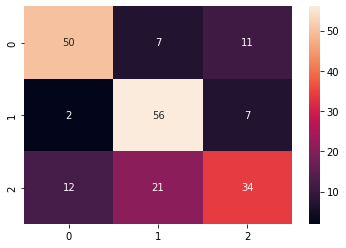

In [21]:
sns.heatmap(cm, annot=True)

### 6. Importanta feature-urilor

Intuitiv anumite feature-uri sunt mai importante decat altele cand vine vorba de clasificare. Prezenta cuvantului "happy" sau "sad" ne poate oferi informatii despre sentimentul unui text, pe cand cuvantul "car", nu.

Feature: 0, Score: 0.11837956006934854
Feature: 1, Score: 0.0
Feature: 2, Score: 0.4172424563910119
Feature: 3, Score: 0.039030730202152863
Feature: 4, Score: 0.0
Feature: 5, Score: 0.21084131505634365
Feature: 6, Score: 0.0
Feature: 7, Score: 0.04661388817258808
Feature: 8, Score: 0.06021961536405184
Feature: 9, Score: 0.10767243474450318


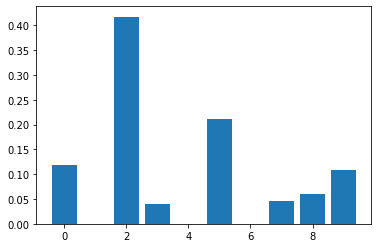

In [22]:
# pentru decision tree avem urmatoare metoda pentru a extrage aceasta importanta
importance = clf.feature_importances_
for i,v in enumerate(importance):
    print(f"Feature: {i}, Score: {v}")

plt.bar([x for x in range(len(importance))], importance)
plt.show()

Pentru alte modele exista diverse alte moduri de a extrage importanta feature-urilor (ex. logistic regression, SVM linear, Random Forest etc.), insa pentru altele este mult mai complicat sau chiar imposibil (ex. SVM cu kernel rbf).

# TASK:

### Deadline: 17 martie ora 23:59.
### Formular pentru trimiterea temei: https://forms.gle/isPikzbiBdNm7AhA6

Vom folosi urmatorul dataset: https://www.kaggle.com/rmisra/news-category-dataset (headline-uri de stiri etichetate conform unei liste de categorii).

1. (optional) Intrucat setul de date contine multe categorii, puteti pastra exemplele din 4-5 clase (selectate de catre voi) si sa rezolvati problema de clasificare doar pentru aceste exemple
2. Incercati mai multe metode de preprocesare si tokenizare a textelor pentru a obtine reprezentari de tip Bag-of-Words (stergeti/nu stergeti stop words, lematizati sau aplicati stemming, pastrati sau eliminati punctuatia, normalizati folosind standardizare, L1, L2 sau Tf-Idf). Implementati **3** astfel de combinatii.
3. Impartiti setul de date in 80% train, 20% test, iar pentru fiecare metoda de preprocesare antrenati un model ales de voi (diferit de Decision Tree) pe datele de train
4. Evaluati modelul pe datele de test, determinand acuratete, precizie, recall, f1, si stabiliti care metoda de procesare a textelor a adus rezultate mai bune.
5. Determinati pentru acest caz care au fost top 10 cele mai importante feature-uri (cuvinte).
6. Folosind aceasta metoda de procesare a textelor, antrenati alte doua modele diferite la alegere si comparati performanta cu modelul original.
7. Pentru cel mai bun model afisati metricile la nivel de clasa (classification report) si matricea de confuzie.

In [1]:
# Horjea Cosmin-Marian
# 343
import json
import pandas as pd

In [2]:
path = 'news.json'
news = []
with open(path) as files:
    for file in files:
        news.append(json.loads(file))
data = pd.DataFrame(news)
data.head()


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [6]:
# 1
new_data = data[(data.category == "CRIME") | 
                (data.category == "POLITICS") | 
                (data.category == "ENTERTAINMENT") |
                (data.category == "SPORTS") |
                (data.category == "TECH") ]

# ["CRIME", "POLITICS","COMEDY", "SPORTS", "TECH"]
print(new_data.category.unique())
# keep only headline and category
new_data = new_data[['headline', 'category']]
new_data.head()


['CRIME' 'ENTERTAINMENT' 'POLITICS' 'SPORTS' 'TECH']


,headline,category
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 57,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT


In [23]:
import spacy
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import RidgeClassifier

nlp = spacy.load('en_core_web_sm')
stop_words_spacy = nlp.Defaults.stop_words

stemmer = SnowballStemmer(language="english")


In [43]:
# 2
def preprocessor_delete_stopwords(text:str):
    stop_words = set(stop_words_spacy)
    return " ".join([word for word in text.split() if word not in stop_words])

def preprocessor_lemmatize(text):
    doc = nlp(text)
    return " ".join([word.lemma_ for word in doc])

def preprocessor_stemming(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

def preprocessor_no_punctuation(text):
    text = [re.sub(r'[^\w\s]', '', word) for word in text.split()]
    return " ".join(text)

def dummy_tokenize(text):
    return text.split(" ")

def stemming_tokenize(text):
    return [stemmer.stem(word) for word in text.split()]

def lemmatize_tokenize(text):
    doc = nlp(text)
    return [word.lemma_ for word in doc]

cv_delStopwords_and_lemmatize = CountVectorizer(
    preprocessor=preprocessor_lemmatize,
    tokenizer=dummy_tokenize,
    stop_words='english',
    token_pattern=None,
    max_features=5,
)

cv_delStopwords_and_stemming = CountVectorizer(
    preprocessor=preprocessor_delete_stopwords,
    tokenizer=stemming_tokenize,
    token_pattern=None,
    max_features=5,
)

cv_tfidf_delStopwords_and_stemming_l1 = TfidfVectorizer(
    preprocessor=preprocessor_delete_stopwords,
    tokenizer=stemming_tokenize,
    token_pattern=None,
    max_features=5,
    norm="l1"
)


In [26]:
from sklearn.linear_model import SGDClassifier


In [45]:
# 3
X_train, X_test, y_train, y_test = train_test_split(
    new_data.headline, new_data.category, test_size=0.2, random_state=42)

clf_1 = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
X_train_1 = cv_delStopwords_and_lemmatize.fit_transform(X_train)
X_test_1 = cv_delStopwords_and_lemmatize.transform(X_test)
# 4
score = (clf_1.fit(X_train_1, y_train)).score(X_test_1, y_test)


C:\Users\horje\.pyenv\pyenv-win\versions\3.9.6\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make'] not in stop_words.
  warnings.warn(
C:\Users\horje\.pyenv\pyenv-win\versions\3.9.6\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [46]:
def printScores(clf, X_test, y_test):
    print("Accuracy:", metrics.accuracy_score(y_test, clf.predict(X_test)))
    print("Precision:", metrics.precision_score(y_test, clf.predict(X_test), average="macro"))
    print("Recall:", metrics.recall_score(y_test, clf.predict(X_test), average="macro"))
    print("F1:", metrics.f1_score(y_test, clf.predict(X_test), average="macro"))

In [50]:
printScores(clf_1, X_test_1, y_test)

Accuracy: 0.6149231029237789
Precision: 0.2455520601408258


C:\Users\horje\.pyenv\pyenv-win\versions\3.9.6\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.2659761680457683
F1: 0.24694970824305215


In [48]:
clf_2 = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
X_train_2 = cv_delStopwords_and_stemming.fit_transform(X_train)
X_test_2 = cv_delStopwords_and_stemming.transform(X_test)
clf_2.fit(X_train_2, y_train)
printScores(clf_2, X_test_2, y_test)

C:\Users\horje\.pyenv\pyenv-win\versions\3.9.6\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\horje\.pyenv\pyenv-win\versions\3.9.6\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.541406117965185
Precision: 0.2155829477762296
Recall: 0.20648779087293515
F1: 0.1704324054362664


In [49]:
clf_3 = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
X_train_3 = cv_tfidf_delStopwords_and_stemming_l1.fit_transform(X_train)
X_test_3 = cv_tfidf_delStopwords_and_stemming_l1.transform(X_test)
clf_3.fit(X_train_3, y_train)
printScores(clf_3, X_test_3, y_test)

C:\Users\horje\.pyenv\pyenv-win\versions\3.9.6\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\horje\.pyenv\pyenv-win\versions\3.9.6\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4787899273280379
Precision: 0.1781322915402957
Recall: 0.21592076474567629
F1: 0.19464452593195705


Observam cele mai bune scoruri in primul model, pe care am aplicat lematizare si am sters stopwords

In [57]:
# 5

importance = clf_1.coef_
for i,v in enumerate(importance):
    print(f"Feature: {i}, Score: {v}")


Feature: 0, Score: [ 4.20753232e-02  3.06130794e-16  3.28530609e-16 -8.41506465e-02
 -1.68301293e-01]
Feature: 1, Score: [ 9.67732435e-01 -2.98664190e-15  1.26225970e-01 -2.94527263e-01
 -1.93546487e+00]
Feature: 2, Score: [-0.79943114 -0.37867791 -0.42075323  0.08415065  1.76716358]
Feature: 3, Score: [ 4.97275876e-15 -4.20753232e-02 -4.20753232e-02  4.20753232e-02
 -8.41506465e-02]
Feature: 4, Score: [-4.20753232e-02 -8.13859917e-16 -4.20753232e-02  1.99358347e-15
 -1.68301293e-01]


In [58]:
# 6
from sklearn.ensemble import RandomForestClassifier

rfClassifier = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rfClassifier.fit(X_train_1, y_train)
printScores(rfClassifier, X_test_1, y_test)



Accuracy: 0.6196552306912286


C:\Users\horje\.pyenv\pyenv-win\versions\3.9.6\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.25488169083207973
Recall: 0.26347873308322545
F1: 0.2450227607626875


In [59]:
from sklearn.ensemble import GradientBoostingClassifier

gbClassifier = GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=0)
gbClassifier.fit(X_train_1, y_train)
printScores(gbClassifier, X_test_1, y_test)


Accuracy: 0.6224438059827615
Precision: 0.45542316254884563


C:\Users\horje\.pyenv\pyenv-win\versions\3.9.6\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.2659889735204015
F1: 0.24784862462066864


C:\Users\horje\.pyenv\pyenv-win\versions\3.9.6\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\horje\.pyenv\pyenv-win\versions\3.9.6\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        CRIME       0.00      0.00      0.00       683
ENTERTAINMENT       0.66      0.40      0.50      3254
     POLITICS       0.61      0.93      0.74      6517
       SPORTS       1.00      0.00      0.00       976
         TECH       0.00      0.00      0.00       404

     accuracy                           0.62     11834
    macro avg       0.46      0.27      0.25     11834
 weighted avg       0.60      0.62      0.54     11834



C:\Users\horje\.pyenv\pyenv-win\versions\3.9.6\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

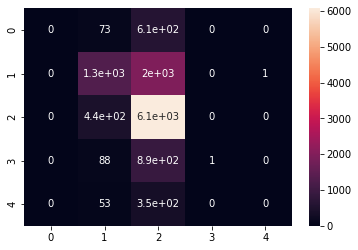

In [62]:
# 7
# cel mai bun model este acela de Gradient Boosting Classifier
cm = metrics.confusion_matrix(y_test, gbClassifier.predict(X_test_1))
print(metrics.classification_report(y_test, gbClassifier.predict(X_test_1)))
sns.heatmap(cm, annot=True)